In [150]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, GroupKFold, cross_validate, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, mean_squared_error, roc_curve, f1_score, auc, balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

from scipy.stats import f_oneway
import scipy.stats as st

sns.set_theme()
cmap = sns.color_palette("vlag", as_cmap=True)

random_state = 42
binary = True

# Project

## Load data

In [151]:
data = pd.read_csv('../description/HR_data.csv')
data = data.drop(['Unnamed: 0'], axis=1)

data.head()

,HR_Mean,HR_Median,HR_std,HR_Min,HR_Max,HR_AUC,Round,Phase,Individual,Puzzler,Frustrated,Cohort
0,77.965186,78.00,3.345290,73.23,83.37,22924.945,round_3,phase3,1,1,1,D1_1
1,70.981097,70.57,2.517879,67.12,78.22,21930.400,round_3,phase2,1,1,5,D1_1
2,73.371959,73.36,3.259569,67.88,80.22,21647.085,round_3,phase1,1,1,0,D1_1
3,78.916822,77.88,4.054595,72.32,84.92,25258.905,round_2,phase3,1,1,1,D1_1
4,77.322226,74.55,6.047603,70.52,90.15,23890.565,round_2,phase2,1,1,5,D1_1


## Data preparation

In [152]:
features = ['HR_Mean', 'HR_Median', 'HR_std', 'HR_Min', 'HR_Max', 'HR_AUC', 'Phase_1', 'Phase_2', 'Phase_3']
target = 'Frustrated'

# Standardizing and encoding data
scaler = StandardScaler()
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder()

# Encoding categorical variables
categorical_cols = ['Round', 'Cohort']
for feature in categorical_cols:
    data[feature] = label_encoder.fit_transform(data[feature])

phase = one_hot_encoder.fit_transform(data[['Phase']])
phase = pd.DataFrame(phase.toarray(), columns=['Phase_1', 'Phase_2', 'Phase_3'])
data = pd.concat([data, phase], axis=1)
data = data.drop('Phase', axis=1)

# Standardizing numeric variables
for feature in features:
    data[feature] = scaler.fit_transform(data[[feature]])

# Encoding target variables
data[target] = np.where(data[target] > 3, 1, 0)

X = data[features]
y = data[target]
groups = data['Individual']

In [153]:
y.value_counts()

Frustrated
0    121
1     47
Name: count, dtype: int64

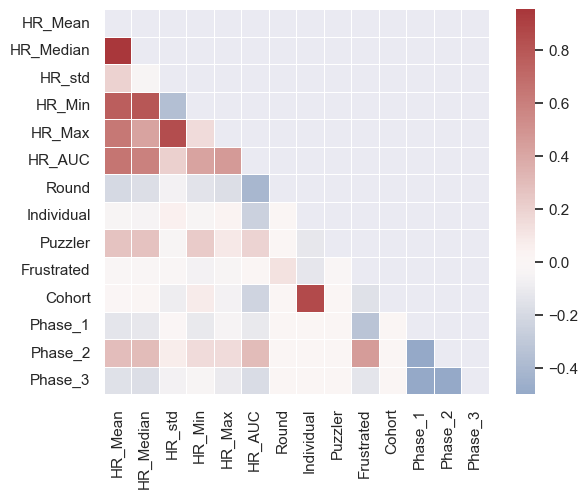

In [154]:
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": 1});

## Model selection

In [155]:
models = {
    'Baseline': DummyClassifier(strategy='most_frequent'),
    'Logistic': LogisticRegression(random_state=random_state, max_iter=1000, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(random_state=random_state),
    'knn': KNeighborsClassifier(5),
    'Random Forest': RandomForestClassifier(random_state=random_state, class_weight='balanced')
}

## Evaluation

In [156]:
from sklearn.metrics import precision_score, recall_score, accuracy_score


folds = 5
gkf = GroupKFold(n_splits=folds)
results = []
predictions = {}
raw_result = []

scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro', zero_division=1),
    'recall': 'recall_macro',
    'roc_auc': 'roc_auc',
    'mse': make_scorer(mean_squared_error),
    'f1': make_scorer(f1_score, average='macro', zero_division=1)
}

for name, model in models.items():
    cross = cross_validate(model, X, y, groups=groups, cv=gkf, scoring=scoring_metrics)
    
    precision_scores = cross['test_precision']
    acc_scores = cross['test_accuracy']
    recall_scores = cross['test_recall']
    f1_scores = cross['test_f1']
    mse_scores = cross['test_mse']
    roc_auc = cross['test_roc_auc']

    raw_result.append({
        'Model': name,
        'Accuracy': acc_scores,
        'MSE': mse_scores,
        'F1-Score': f1_scores,
        'ROC-AUC': roc_auc,
        'Precision': precision_scores,
        'Recall': recall_scores
    })
    results.append({
        'Model': name,
        'Accuracy Mean': np.mean(acc_scores),
        'Conf':  st.bootstrap((acc_scores,), np.mean, n_resamples=1000).confidence_interval,
        'Accuracy Std': np.std(acc_scores),
        'Precision Mean': np.mean(precision_scores),
        'Recall Mean': np.mean(recall_scores),
        'f1 Mean': np.mean(f1_scores),
        'ROC AUC': np.mean(roc_auc),
        'MSE Mean': np.mean(mse_scores),
        'MSE Std': np.std(mse_scores)
    })
    y_pred = cross_val_predict(model, X, y, groups=groups, cv=gkf, method='predict')
    y_proba = cross_val_predict(model, X, y, groups=groups, cv=gkf, method='predict_proba') if hasattr(model, "predict_proba") else None
    predictions[name] = (y_pred, y_proba)
raw_result = pd.DataFrame(raw_result)
results_df = pd.DataFrame(results)
results_df

,Model,Accuracy Mean,Conf,Accuracy Std,Precision Mean,Recall Mean,f1 Mean,ROC AUC,MSE Mean,MSE Std
0,Baseline,0.722222,"(0.6722222222222222, 0.788888888888889)",0.068041,0.861111,0.500000,0.418460,0.500000,0.277778,0.068041
1,Logistic,0.733333,"(0.6888888888888889, 0.7777777777777778)",0.054433,0.688387,0.714275,0.688834,0.740165,0.266667,0.054433
2,Decision Tree,0.658333,"(0.5916666666666666, 0.7277777777777776)",0.075359,0.601418,0.602727,0.590608,0.601060,0.341667,0.075359
3,knn,0.744444,"(0.6888888888888888, 0.7833333333333334)",0.056656,0.704528,0.654893,0.657001,0.675635,0.255556,0.056656
4,Random Forest,0.750000,"(0.7, 0.8)",0.060858,0.696706,0.649380,0.656779,0.663226,0.250000,0.060858


In [157]:
# Confusion Matrix and Classification Report
for name, (y_pred, _) in predictions.items():
    print(f"Confusion Matrix for {name}:")
    print(confusion_matrix(y, y_pred))
    print(f"Classification Report for {name}:")
    print(classification_report(y, y_pred, zero_division=1))

Confusion Matrix for Baseline:
[[121   0]
 [ 47   0]]
Classification Report for Baseline:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84       121
           1       1.00      0.00      0.00        47

    accuracy                           0.72       168
   macro avg       0.86      0.50      0.42       168
weighted avg       0.80      0.72      0.60       168

Confusion Matrix for Logistic:
[[91 30]
 [14 33]]
Classification Report for Logistic:
              precision    recall  f1-score   support

           0       0.87      0.75      0.81       121
           1       0.52      0.70      0.60        47

    accuracy                           0.74       168
   macro avg       0.70      0.73      0.70       168
weighted avg       0.77      0.74      0.75       168

Confusion Matrix for Decision Tree:
[[90 31]
 [25 22]]
Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       

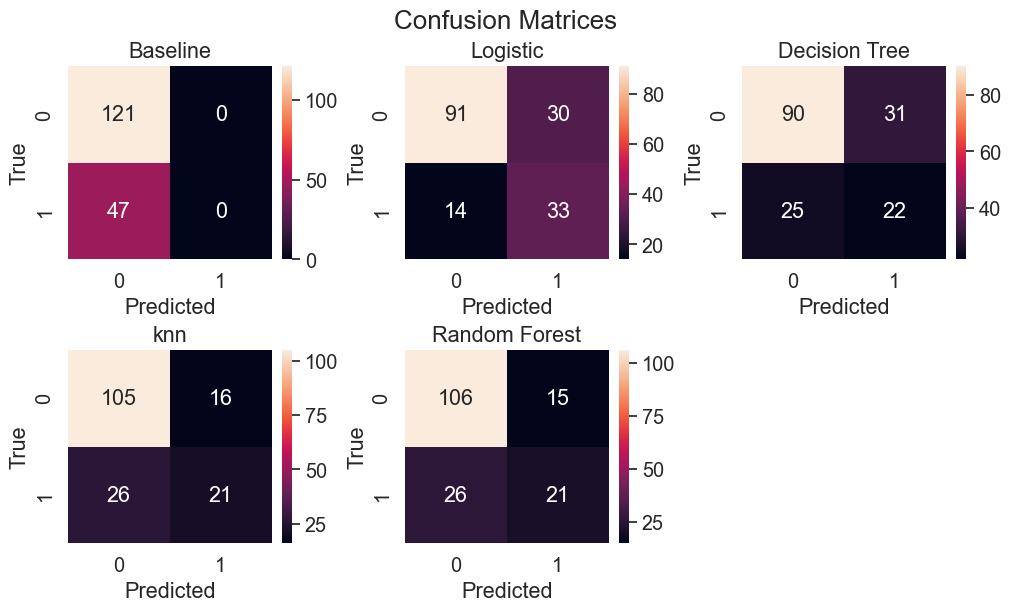

In [158]:
sns.set(font_scale=1.3)
fig, axs = plt.subplots(2, 3, figsize=(10, 6), constrained_layout=True)
fig.suptitle('Confusion Matrices')
for idx, (name, (y_pred, _)) in enumerate(predictions.items()):
    ax = axs[idx // 3, idx % 3]
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='g', ax=ax)
    ax.set_title(f'{name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
fig.delaxes(axs[1,2])

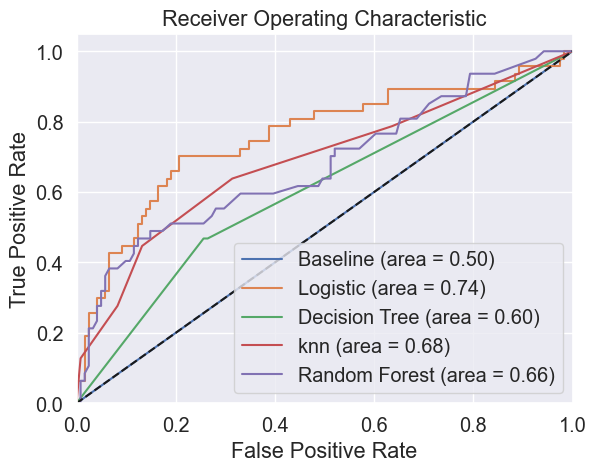

In [159]:
plt.figure()
for name, (_, y_proba) in predictions.items():
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y, y_proba[:, 1])
        roc_auc = results_df[results_df['Model'] == name]['ROC AUC'].values[0] #auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

C:\Users\Rune\AppData\Local\Temp\ipykernel_21508\2728331441.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(features)[indices], palette='viridis')


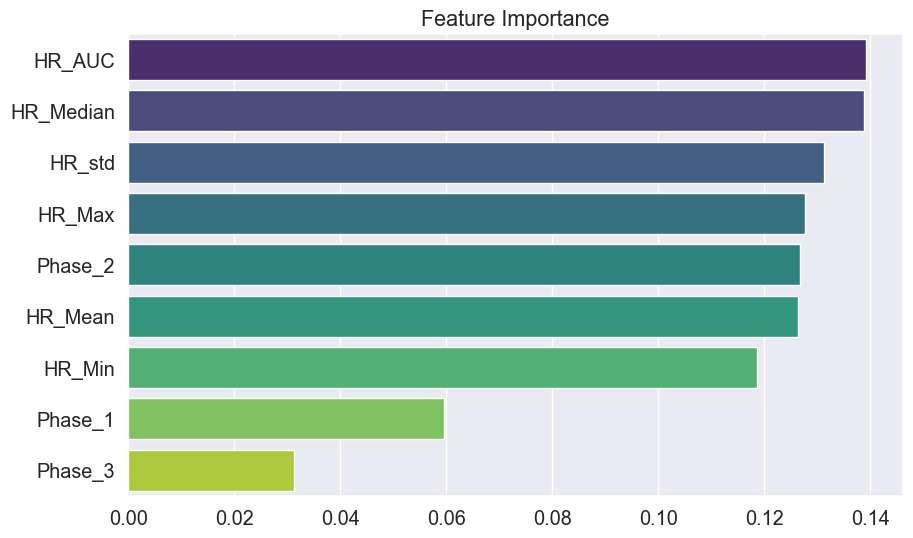

In [160]:
rf = RandomForestClassifier()
rf.fit(X, y)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Seaborn feature importance plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=np.array(features)[indices], palette='viridis')
plt.title('Feature Importance')
plt.show()

## Statistics

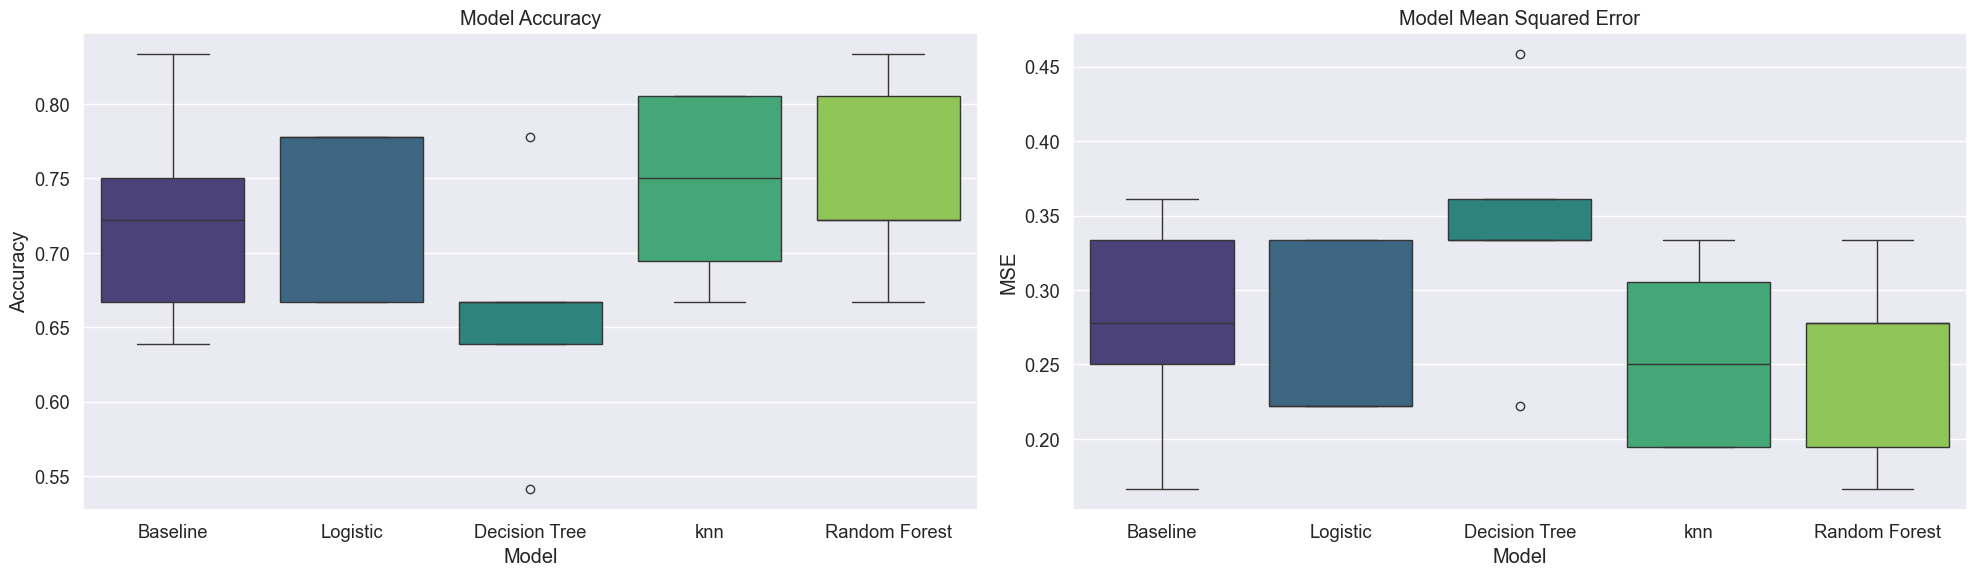

In [161]:
acc_df = raw_result.explode('Accuracy')
mse_df = raw_result.explode('MSE')
roc_auc_df = raw_result.explode('ROC-AUC')

sns.set(font_scale=1.2)

# Create figures for the plots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Accuracy Boxplot
sns.boxplot(x='Model', y='Accuracy', data=acc_df, ax=axs[0], hue="Model", palette='viridis')
axs[0].set_title('Model Accuracy')

# MSE Boxplot
sns.boxplot(x='Model', y='MSE', data=mse_df, ax=axs[1], hue="Model", palette='viridis')
axs[1].set_title('Model Mean Squared Error')

plt.tight_layout()
plt.show()

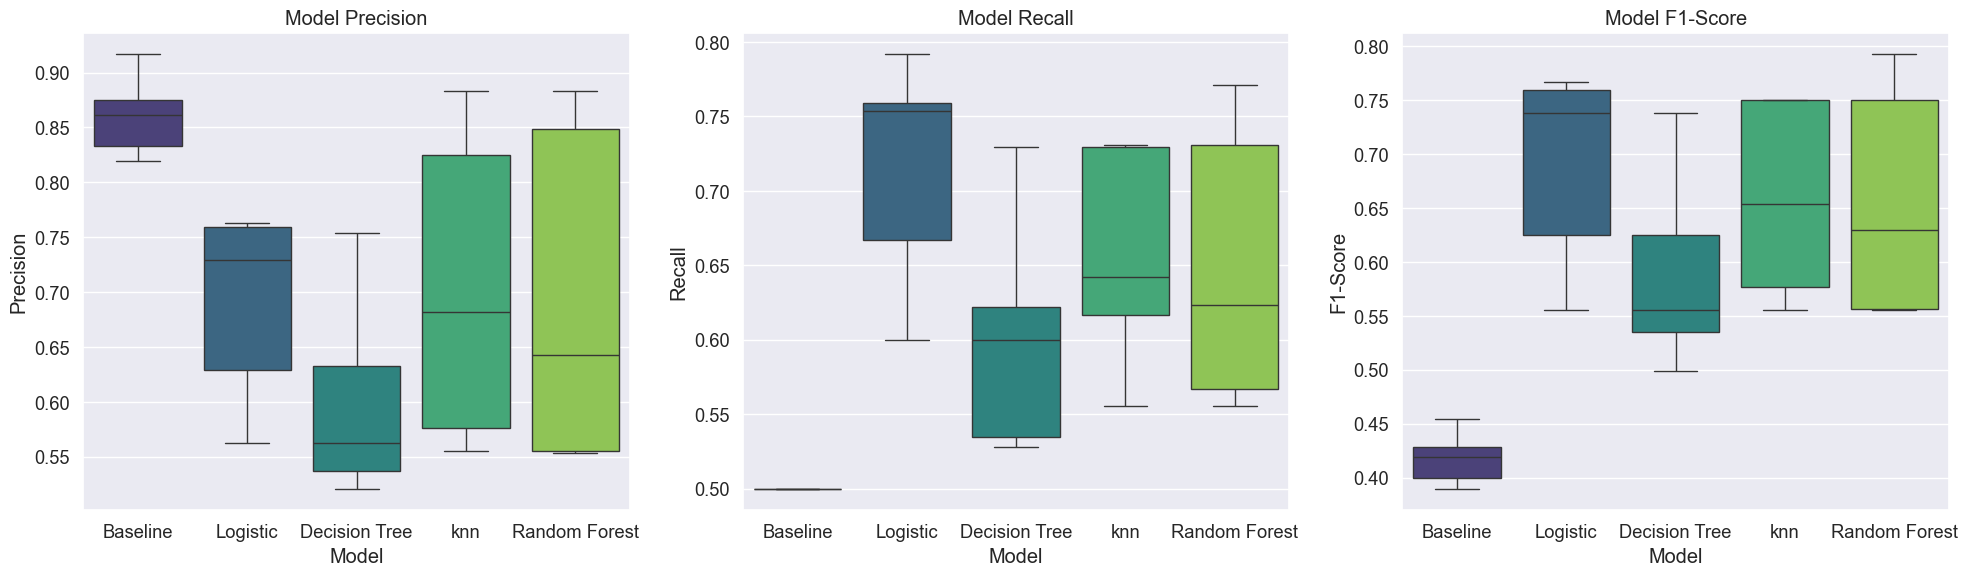

In [162]:
precision_df = raw_result.explode('Precision')
recall_df = raw_result.explode('Recall')
f1_df = raw_result.explode('F1-Score')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

# Precision Boxplot
sns.boxplot(x='Model', y='Precision', data=precision_df, ax=axs[0], hue="Model", palette='viridis')
axs[0].set_title('Model Precision')

# Recall Boxplot
sns.boxplot(x='Model', y='Recall', data=recall_df, ax=axs[1], hue="Model", palette='viridis')
axs[1].set_title('Model Recall')

# F1-Score Boxplot
sns.boxplot(x='Model', y='F1-Score', data=f1_df, ax=axs[2], hue="Model", palette='viridis')
axs[2].set_title('Model F1-Score')


plt.tight_layout()
plt.show()

In [163]:
# Descriptive statistics for each model
print("Descriptive Statistics for Model Performance:")
print(results_df.groupby('Model')[['Accuracy Mean', 'MSE Mean']].describe())

Descriptive Statistics for Model Performance:
              Accuracy Mean                                              \
                      count      mean std       min       25%       50%   
Model                                                                     
Baseline                1.0  0.722222 NaN  0.722222  0.722222  0.722222   
Decision Tree           1.0  0.658333 NaN  0.658333  0.658333  0.658333   
Logistic                1.0  0.733333 NaN  0.733333  0.733333  0.733333   
Random Forest           1.0  0.750000 NaN  0.750000  0.750000  0.750000   
knn                     1.0  0.744444 NaN  0.744444  0.744444  0.744444   

                                  MSE Mean                                    \
                    75%       max    count      mean std       min       25%   
Model                                                                          
Baseline       0.722222  0.722222      1.0  0.277778 NaN  0.277778  0.277778   
Decision Tree  0.658333  0.658333

In [164]:
targets = ['Accuracy', 'MSE', 'F1-Score', 'ROC-AUC', 'Precision', 'Recall']
model_names = ['Logistic', 'Decision Tree', 'knn', 'Random Forest']


for target in targets:
    print(f"ANOVA test result for {target} across Models:")
    f_stat, p_val = f_oneway(*(raw_result[raw_result['Model'] == model][target].values[0] for model in model_names))
    print(f"F-statistic = {f_stat:.3f}, p-value = {p_val:.3f}")

    if p_val < 0.05:
        print(f"There is a statistically significant difference between the model {target}.")
    else:
        print(f"There is no statistically significant difference between the model {target}.")
    print('\n----------------------------\n')


ANOVA test result for Accuracy across Models:
F-statistic = 1.875, p-value = 0.175
There is no statistically significant difference between the model Accuracy.

----------------------------

ANOVA test result for MSE across Models:
F-statistic = 1.875, p-value = 0.175
There is no statistically significant difference between the model MSE.

----------------------------

ANOVA test result for F1-Score across Models:
F-statistic = 0.893, p-value = 0.466
There is no statistically significant difference between the model F1-Score.

----------------------------

ANOVA test result for ROC-AUC across Models:
F-statistic = 1.307, p-value = 0.307
There is no statistically significant difference between the model ROC-AUC.

----------------------------

ANOVA test result for Precision across Models:
F-statistic = 0.724, p-value = 0.552
There is no statistically significant difference between the model Precision.

----------------------------

ANOVA test result for Recall across Models:
F-statistic